# HOT and LOT Region Sequence Generation

In [1]:
# File names
sequence = 'male.hg19.fa'
hot_regions = 'maphot_hs_selection_reg_cx_denP05_any.bed'
output_hot = 'hot_regions_05_any.fa'
output_lot = 'lot_regions_05_any.fa'

In [2]:
from Bio import SeqIO

# Converting genome to a dictionary with chromosome keys
record_dict = SeqIO.to_dict(SeqIO.parse(sequence, "fasta"))

In [3]:
# Parsing BED file
with open(hot_regions) as f:
    lines = f.readlines()
    lines = [line.rstrip().split()[0:4] for line in lines]

Text(0, 0.5, 'Frequency')

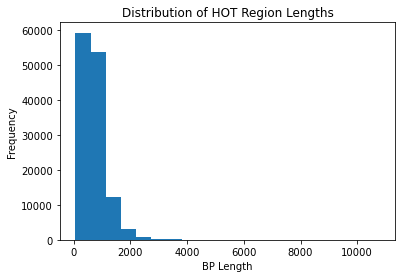

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting the distribution of hot region lengths
sizes = []
for entry in lines:
    sizes.append(int(entry[2]) - int(entry[1]))
arr = np.array(sizes)

plt.hist(arr, bins=20)
plt.title('Distribution of HOT Region Lengths')
plt.xlabel('BP Length')
plt.ylabel('Frequency')

In [5]:
index = '0'
curr_chromosome = 'chr1'
negative_set_indices = []

# Looping over chromosomes to find LOT region index ranges
for entry in lines:
    if entry[0] != curr_chromosome:
        negative_set_indices.append([curr_chromosome, index, len(record_dict[curr_chromosome].seq)])
        index = '0'
        curr_chromosome = entry[0]
    negative_set_indices.append([curr_chromosome, index, entry[1]])
    index = entry[2]

In [6]:
import random

# Approximate number of negative test sets to generate - e.g. (5 * #positive)
multiplier = 1

negative_set_indices_resized = []

# Iterating over possible ranges to get LOT regions
for x in negative_set_indices:
    curr_set = set()
    # Random size from HOT region distribution
    l = random.choice(sizes)
    # Ensuring that the region is long enough to sample from
    if int(x[2])-l < int(x[1]):
        continue
    num = min(multiplier,(int(x[2])-int(x[1]))//10)
    for _ in range(num):
        a = random.randint(int(x[1]), int(x[2])-l)
        # Ensuring nonoverlapping samples
        while any(a>=i and a<= i+l for i in curr_set):
            a = random.randint(int(x[1]), int(x[2])-l)
        curr_set.add(a)
    lis = sorted(list(curr_set))
    for y in lis:
        negative_set_indices_resized.append([x[0], str(y), str(y+l)])

In [7]:
import pandas as pd

# Printing HOT region indices, LOT region indices, and LOT region resized indices
df1 = pd.DataFrame(lines, columns = ['Chromosome', 'Start', 'End', 'Name'])
print(df1)
df2 = pd.DataFrame(negative_set_indices, columns = ['Chromosome', 'Start', 'End'])
print(df2)
df3 = pd.DataFrame(negative_set_indices_resized, columns = ['Chromosome', 'Start', 'End'])
print(df3)

       Chromosome      Start        End          Name
0            chr1     713833     714630      HOT-GM.1
1            chr1     805156     805471      HOT-GM.2
2            chr1     839882     840421      HOT-GM.3
3            chr1     840584     841020      HOT-GM.4
4            chr1     894181     894983      HOT-GM.5
...           ...        ...        ...           ...
129351       chrX  155110631  155111614  HOT-K5.31339
129352       chrX  155117856  155118220  HOT-K5.31340
129353       chrX  155123251  155123707  HOT-K5.31341
129354       chrX  155227140  155227504  HOT-K5.31342
129355       chrX  155231177  155231689  HOT-K5.31343

[129356 rows x 4 columns]
       Chromosome      Start        End
0            chr1          0     713833
1            chr1     714630     805156
2            chr1     805471     839882
3            chr1     840421     840584
4            chr1     841020     894181
...           ...        ...        ...
129467       chrX  154665003  155110631
12946

In [8]:
# Looking up base pair sequence coordinates and building output file contents

# Building HOT Regions fasta file
hot = ''
for entry in lines:
    sequence = str(record_dict[entry[0]][int(entry[1]):int(entry[2])].seq)
    # Removing any newlines from stored genome entry
    sequence_no_newline = sequence.replace('\n', '')
    hot = hot + '>' + entry[3] + '\n' + sequence_no_newline + '\n'
# Stripping last newline of file
hot =  hot.rstrip('\n') 
with open(output_hot,'w+') as f:
    f.write(hot)
    
# Building LOT Regions fasta file
lot = ''
i = 1
for entry in negative_set_indices_resized:
    sequence = str(record_dict[entry[0]][int(entry[1]):int(entry[2])].seq)
    # Removing any newlines from stored genome entry
    sequence_no_newline = sequence.replace('\n', '')
    lot = lot + '>LOT.' + str(i) + '\n' + sequence_no_newline + '\n'
    i += 1
# Stripping last newline of file
lot =  lot.rstrip('\n') 
with open(output_lot,'w+') as f:
    f.write(lot)